# Generalized Linear Models using Pynapple & NeMos
In this notebook, we will use NeMos and Pynapple packages (supported by the [Flatiron Institute](https://neurorse.flatironinstitute.org)), to model spiking neural data using [Generalized Linear Models (GLM)](https://en.wikipedia.org/wiki/Generalized_linear_model). We will explain what GLMs are and which are their components, then use [Pynapple](https://pynapple.org) and [NeMos](https://nemos.readthedocs.io/en/latest/) python packages to preprocess real data from the Primary Visual Cortex (VISp) of mice, and use a GLM model to predict spiking neural data as a function of passive visual stimuli. Moreover, we will also compare this model including an extra predictor: spike history, to assess whether adding history as a predictor improves the performance.

We will be analyzing data from the [Visual Coding - Neuropixels dataset](https://portal.brain-map.org/circuits-behavior/visual-coding-neuropixels), published by the Allen Institute. This dataset uses [extracellular electrophysiology probes](https://www.nature.com/articles/nature24636) to record spikes from multiple regions in the brain during passive visual stimulation. For simplicity, we will focus on the activity of neurons in the visual cortex (VISp) during passive exposure to full-field flashes of color either black (coded as "-1.0") or white (coded as "1.0") in a gray background.

### Background on GLMs


A GLM is a regression model which trains a filter to predict a value (output) as it relates to some other variable (or input). In the neuroscience context, we can use a particular type of GLM to predict spikes: the linear-nonlinear-Poisson (LNP) model. This type of model receives one or more inputs and then sends them through a linear  "filter" or transformation, passes said transformation through a nonlinearity to get the firing rate and uses that firing rate as the mean of a Poisson distribution to generate spikes. 

![LNP model schematic](../../data/images/lnp_model.png)
<p align="center">
LNP model schematic. Modified from <a href="https://www.nature.com/articles/nature07140">Pillow et al., 2008</a>
</p>

1. Sends the inputs through a linear "filter" or transformation
     
    The inputs (also known as "predictors") are first passed through a linear transformation:
    
    $$
    \begin{aligned}
    L(X) = WX + c
    \end{aligned}
    $$

    Where $X$ is the input (in matrix form), $W$ is a matrix and $c$ is a vector (intercept).

    $L$ scales (makes bigger or smaller) or shifts (up or down) the input. When there is zero input, this is equivalent to changing the baseline rate of the neuron, which is how the intercept should be interpreted. So far, this is the same treatment of an ordinary linear regression. 

2. Passes the transformation through a nonlinearity to get the firing rate.
    
    The aim of a LNP model is to predict the firing rate of a neuron and use it to generate spikes, but if we were only to keep $L(X)$ as it is, we would quickly notice that we could obtain negative values for firing rates, which makes no sense! This is what the nonlinearity part of the model handles: by passing the linear transformation through an exponential function, it is assured that the resulting firing rate will always be non-negative. 

    As such, the firing rate in a LNP model is defined:

    $$
    \begin{aligned}
    \lambda =  exp(L(X))
    \end{aligned}
    $$

    where $\lambda$ is a vector containing the firing rates corresponding to each timepoint.

:::{admonition} A note on nonlinearity
:class: info
:class: dropdown


In NeMoS, the nonlinearity is kept fixed. We default to the exponential, but a small number of other choices, such as soft-plus, are allowed. The allowed choices guarantee both the non-negativity constraint described above, as well as convexity, i.e. a single optimal solution. In principle, one could choose a more complex nonlinearity, but convexity is not guaranteed in general.
:::

:::{admonition} What is the difference between a "link function" and the "nonlinearity"?
:class: info
:class: dropdown

The link function states the relationship between the linear predictor and the mean of the distribution function. If $g$ is a link function, $L(⋅)$ is the linear predictor and $\lambda$ the mean of the distribution function:

$$
\begin{aligned}
g(\lambda) = L(⋅)
\end{aligned}
$$

$$
\begin{aligned}
\lambda = g^{-1}(L(⋅))
\end{aligned}
$$

the "nonlinearity" is the name for the inverse of the link function $g^{-1}(⋅)$.

:::

3. Uses the firing rate as the mean of a Poisson distribution to generate spikes

    In this type of GLM, each spike train is modeled as a sample from a Poisson distribution whose mean is the firing rate — that is, the output of the linear-nonlinear components of the model.

    Spiking is a stochastic process. This means that a given firing rate can lead to many different possible spike trains. Since the model could generate an infinite number of spike train realizations, how do we evaluate how well it explains the single observed spike train? We do this by computing the log-likelihood: it quantifies how likely it is to observe the actual spike train given the predicted firing rate. If $ y(t) $ is the observed spike count and $ \lambda(t) $ is the predicted firing rate at time $ t $, then the log-likelihood at time $ t $:

    $$
    \log P(y(t) \mid \lambda(t)) = y(t)\log\lambda(t) - \lambda(t) -\log(y(t)!)
    $$

    However, the term $ -\log(y(t)!) $ does not depend on $ \lambda $, and therefore is constant with respect to the model. As a result, it is usually dropped during optimization, leaving us with the simplified log-likelihood:

    $$
    \log P(y(t) \mid \lambda(t)) = y(t) \log \lambda(t) - \lambda(t)
    $$

    This forms the loss function for LNPs. In practice, we aim to maximize this log-likelihood, which is equivalent to minimizing the negative log-likelihood — that is, finding the firing rate $\lambda(t)$ that makes the observed spike train as likely as possible under the model.


:::{admonition} Why using GLMs?
:class: info
:class: dropdown

1. Why not just use linear regression? Because neural data breaks its key assumptions. Linear regression expects normally distributed data with constant variance, but spike counts are non-Gaussian. Even more problematic, neural variability isn't constant: neurons that fire more frequently also tend to be more variable. This violates the homoscedasticity assumption that's fundamental to linear regression, making GLMs a much more suitable framework for modeling neural activity.

2. GLMs are as easy to fit as linear regression! The objective function (negative log-likelihood) of GLMs with canonical link functions (such as log link which we are using here) is convex, which means there is one local minimum and no local maxima, ensuring convergence to the right answer.
:::

:::{admonition} More resources on GLMs
:class: seealso
:class: dropdown

If you would like to learn more about GLMs, you can refer to:

- [Nemos GLM tutorial](https://nemos.readthedocs.io/en/latest/background/plot_00_conceptual_intro.html): for a bit more detailed explanation of all the components of a GLM within the NEMOS framework, as well as some nice visualizations of all the steps of the input transformation!
- [Neuromatch Academy GLM tutorial](https://compneuro.neuromatch.io/tutorials/W1D3_GeneralizedLinearModels/student/W1D3_Tutorial1.html): for a bit  more detailed explanation of the components of a GLM, slides and some coding exercises to ensure comprehension.
- [Jonathan Pillow's COSYNE tutorial](https://www.youtube.com/watch?v=NFeGW5ljUoI&t=4230s): for a longer tutorial of all of the components of a GLM, as well as different types of GLM besides LNP
:::

### Learning objectives
- Recognize how to structure data for NeMos using Pynapple
- Recognize how to fit a basic GLM using NeMos
- Recognize basis objects, and explain their usefulness
- Recognize the important terminology necessary for fitting (regularization, tolerance, cross-validation)
- Recognize how to retrieve the parameters and predictions from a fit GLM for interpretation
- Recognize how to evaluate the performance of a model, and compare models

### Create Environment and Import Libraries

In [1]:
'''
try:
    from databook_utils.dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

'''

'\ntry:\n    from databook_utils.dandi_utils import dandi_download_open\nexcept:\n    !git clone https://github.com/AllenInstitute/openscope_databook.git\n    %cd openscope_databook\n    %pip install -e .\n\n'

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pynapple as nap
import nemos as nmo
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore
import itertools

In [3]:
# Parameters for plotting
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", palette="colorblind", font_scale=1.5, rc=custom_params)

### Download data

In [4]:
# Dataset information
dandiset_id = "000021"
dandi_filepath = "sub-726298249/sub-726298249_ses-754829445.nwb"
download_loc = "."

# Download using nemos
# io = nmo.fetch.download_dandi_data(dandiset_id, dandi_filepath)
# nap_nwb = nap.NWBFile(io.read(), lazy_loading=True)

Now that we have downloaded the data, it is very simple to open the dataset with Pynapple

In [5]:
path = "sub-726298249_ses-754829445.nwb"
data = nap.load_file(path)
nwb = data.nwb

print(data)

sub-726298249_ses-754829445
┍━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                                               │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units                                              │ TsGroup     │
│ static_gratings_presentations                      │ IntervalSet │
│ spontaneous_presentations                          │ IntervalSet │
│ natural_scenes_presentations                       │ IntervalSet │
│ natural_movie_three_presentations                  │ IntervalSet │
│ natural_movie_one_presentations                    │ IntervalSet │
│ gabors_presentations                               │ IntervalSet │
│ flashes_presentations                              │ IntervalSet │
│ drifting_gratings_presentations                    │ IntervalSet │
│ timestamps                                         │ Tsd         │
│ running_wheel_rotation                             │ Tsd         │
│ runn

:::{admonition} Pynapple objects
:class: info
:class: dropdown

When printing data, we can see four type of Pynapple objects:
- [```TsGroup```](https://pynapple.org/generated/pynapple.TsGroup.html#pynapple.TsGroup) : Dictionary-like object to group objects with different timestamps 
- [```IntervalSet```](https://pynapple.org/generated/pynapple.IntervalSet.html#pynapple.IntervalSet) : A class representing a (irregular) set of time intervals in elapsed time, with relative operations
- [```Tsd```](https://pynapple.org/generated/pynapple.Tsd.html#pynapple.Tsd) : 1-dimensional container for neurophysiological time series - provides standardized time representation, plus various functions for manipulating times series.
- [```TsdFrame```](https://pynapple.org/generated/pynapple.TsdFrame.html#pynapple.TsdFrame) : Column-based container for neurophysiological time series

To learn more, please refer to the [Pynapple documentation](https://pynapple.org)
:::

## Extraction, preprocessing and stimuli revision

### Extracting Spiking Data

We have a lot of information in ```data```, but we are interested in the units.

In [6]:
units = data["units"]

# See the columns
print(f"columns : {units.metadata_columns}")

# See the dataset
print(units)

columns : ['rate', 'spread', 'velocity_below', 'silhouette_score', 'firing_rate', 'd_prime', 'nn_hit_rate', 'waveform_duration', 'amplitude', 'cluster_id', 'snr', 'local_index', 'peak_channel_id', 'PT_ratio', 'presence_ratio', 'max_drift', 'cumulative_drift', 'repolarization_slope', 'waveform_halfwidth', 'amplitude_cutoff', 'nn_miss_rate', 'quality', 'velocity_above', 'isolation_distance', 'l_ratio', 'recovery_slope', 'isi_violations']
Index      rate      spread    velocity_below    silhouette_score    firing_rate    d_prime    nn_hit_rate    ...
---------  --------  --------  ----------------  ------------------  -------------  ---------  -------------  -----
951763702  2.38003   30.0      nan               nan                 2.38           4.77       0.98           ...
951763707  0.01147   80.0      nan               0.03                0.01           3.48       0.0            ...
951763711  3.1503    50.0      nan               0.17                3.15           6.08       1.0    

Taking a closer look at the columns, we can see there is a lot of information we do not need. We are solely interested in predicting the spiking activity from the neurons from VISp. Thus, we will remove the metadata from all columns except for rate, quality (to make sure we filter the bad-quality neurons) and peak_channel_id (this last one contains relevant information for brain area identification).

In [7]:
def drop_cols(cols_to_keep, data):
    cols_to_remove = [col for col in data.metadata_columns if col not in cols_to_keep]
    data.drop_info(cols_to_remove)
    
# Choose which columns to remove and remove them
cols_to_keep = ['rate', 'quality','peak_channel_id']
drop_cols(cols_to_keep,units)

# See the dataset
print(units)

Index      rate      peak_channel_id    quality
---------  --------  -----------------  ---------
951763702  2.38003   850135036          good
951763707  0.01147   850135036          noise
951763711  3.1503    850135038          good
951763715  6.53      850135038          good
951763720  2.00296   850135044          good
951763724  8.66233   850135044          noise
951763729  11.13402  850135044          noise
...        ...       ...                ...
951777559  0.02108   850139336          good
951777565  0.08143   850139526          noise
951777571  0.20088   850139738          good
951777576  0.01085   850139338          good
951777582  0.1457    850139622          good
951777593  0.0464    850139620          good
951777600  0.0621    850139642          good


Here we dont have the brain area information but we need it, so we need to do some preprocessing to extract brain area from the nwb object using the peak_channel_id metadata. Luckily, Pynapple stored the nwb object as well.

In [8]:
# Units and brain areas those units belong to are in two different places. With the electrodes table, we can map units to their corresponding brain regions.
def get_unit_location(unit_id):
    """Aligns location information from electrodes table with channel id from the units table
    """
    return channel_probes[int(units[unit_id].peak_channel_id)]

channel_probes = {}
electrodes = nwb.electrodes

for i in range(len(electrodes)):
    channel_id = electrodes["id"][i]
    location = electrodes["location"][i]
    channel_probes[channel_id] = location

# Add a new column to include location in our spikes TsGroup
units.brain_area = [channel_probes[int(ch_id)] for ch_id in units.peak_channel_id]

# Remove peak_channel_id because we already got the brain_area information
units.drop_info("peak_channel_id")

print(units)

Index      rate      quality    brain_area
---------  --------  ---------  ------------
951763702  2.38003   good       PoT
951763707  0.01147   noise      PoT
951763711  3.1503    good       PoT
951763715  6.53      good       PoT
951763720  2.00296   good       PoT
951763724  8.66233   noise      PoT
951763729  11.13402  noise      PoT
...        ...       ...        ...
951777559  0.02108   good       LP
951777565  0.08143   noise      DG
951777571  0.20088   good       VISpm
951777576  0.01085   good       LP
951777582  0.1457    good       CA1
951777593  0.0464    good       CA1
951777600  0.0621    good       CA1


### Extracting stimulus data

Mice were exposed to a series of stimuli (gabor patches, flashes, natural images, etc.), out of which we are exclusively interested in flashes presentation for this tutorial.

![visual_stimuli_set.png](../../data/images/visual_stimuli_set.png)

<p align="center">
Visual stimulus set. Modified from <a href="https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/80/75/8075a100-ca64-429a-b39a-569121b612b2/neuropixels_visual_coding_-_white_paper_v10.pdf">Allen Institute for Brain Science</a>
</p>

During the flashes presentation trials, mice were exposed to white or black full-field flashes in a gray background, each lasting 250 ms, and separated by a 2 second inter-trial interval. In total, they were exposed to 150 flashes (75 black, 75 white).

In [9]:
# Extract flashes as an Interval Set object
flashes = data["flashes_presentations"]

# Remove unnecesary columns, similarly to above
cols_to_keep = ['color']
drop_cols(cols_to_keep, flashes)

print(flashes)

# Create an object for white and a separate object for black flashes
flashes_white = flashes[flashes["color"] == "1.0"]
flashes_black = flashes[flashes["color"] == "-1.0"]

index    start           end             color
0        1285.600869922  1285.851080039  -1.0
1        1287.602559922  1287.852767539  -1.0
2        1289.604229922  1289.854435039  -1.0
3        1291.605889922  1291.856100039  -1.0
4        1293.607609922  1293.857807539  1.0
5        1295.609249922  1295.859455039  -1.0
6        1297.610959922  1297.861155039  1.0
...      ...             ...             ...
143      1571.840009922  1572.090212539  -1.0
144      1573.841669922  1574.091877539  1.0
145      1575.843359922  1576.093562539  1.0
146      1577.845019922  1578.095227539  -1.0
147      1579.846709922  1580.096915039  1.0
148      1581.848389922  1582.098595039  1.0
149      1583.850039922  1584.100247539  -1.0
shape: (150, 2), time unit: sec.


In [10]:
def plot_stimulus():
    n_flashes = 5
    n_seconds = 13
    offset = .5

    start = data["flashes_presentations"]["start"].min() - offset
    end = start + n_seconds

    fig, ax = plt.subplots(figsize = (17, 4))
    [ax.axvspan(s, e, color = "silver", alpha=.4, ec="black") for s, e in zip(flashes_white[:n_flashes].start, flashes_white[:n_flashes].end)]
    [ax.axvspan(s, e, color = "black", alpha=.4, ec="black") for s, e in zip(flashes_black[:n_flashes].start, flashes_black[:n_flashes].end)]

    plt.xlabel("Time (s)")
    plt.ylabel("Absent = 0, Present = 1")
    ax.set_title("Stimulus presentation")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.xlim(start-.1,end)
    plt.show()

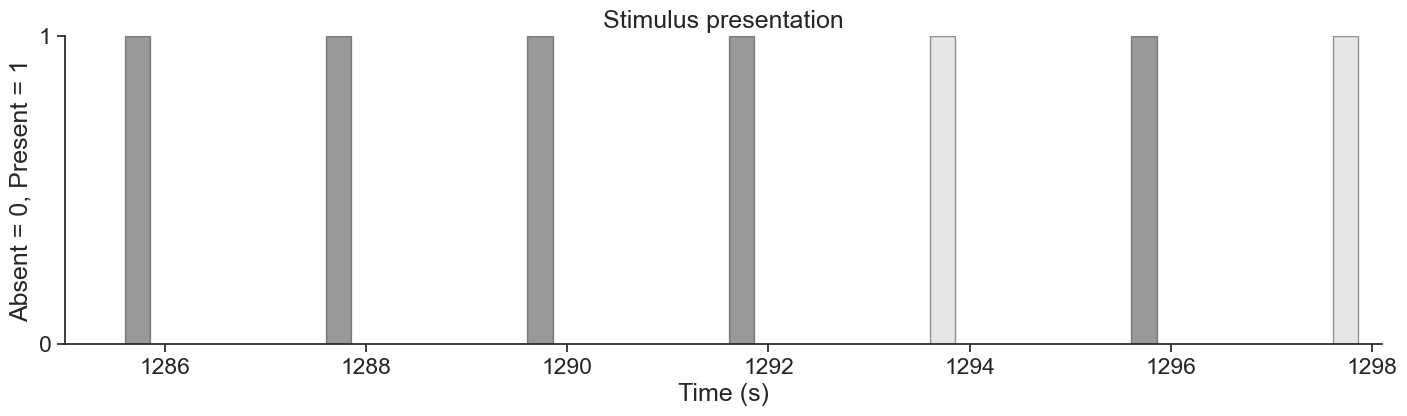

In [11]:
plot_stimulus()

### Preprocessing Spiking Data

There are multiple reasons for filtering units. Here, we will use four criteria: brain area, quality of units, firing rate and responsiveness
1. Brain area: we are interested in analyzing VISp units for this tutorial
2. Quality: we will only select "good" quality units
3. Firing rate: overall, we want units with a firing rate larger than 2 throughout all recordings
4. Responsiveness: Since the goal is to predict firing rate as a function of stimuli, we are now specifically interested in how neurons respond to white and/or black flashes. To focus on meaningful signal, we will (1) exclude units that show no spiking activity during stimulus presentation. To be concise, (2) we will select the most responsive units (top 30% responsiveness), and only use those for further analysis. We define responsiveness as the normalized difference between post stimulus and pre stimulus average firing rate.

:::{admonition} What does it mean for a unit to be of "good" quality?
:class: info
:class: dropdown

More information on unit quality metrics can be found in [Visualizing Unit Quality Metrics ](../visualization/visualize_unit_metrics.ipynb)

:::

In [12]:
# Filter units according 1, 2 and 3 criteria
units = units[
    (units["brain_area"]=="VISp") & 
    (units["quality"]=="good") & 
    (units["rate"]>2.0)
] 
print(units)

Index      rate      quality    brain_area
---------  --------  ---------  ------------
951765440  9.97935   good       VISp
951765454  5.47349   good       VISp
951765460  4.44892   good       VISp
951765467  9.98162   good       VISp
951765478  17.40465  good       VISp
951765485  13.97731  good       VISp
951765508  2.13461   good       VISp
...        ...       ...        ...
951768894  9.16155   good       VISp
951768901  3.99186   good       VISp
951768907  2.85765   good       VISp
951768925  2.28806   good       VISp
951769295  3.27275   good       VISp
951769299  4.57933   good       VISp
951769304  2.04729   good       VISp


Now, to calculate responsiveness, we need to do some preprocessing to align units spiking timestamps with the onset of the stimuli repetitions, and then take an average over the them. For this, we will use the [```compute_perievent```](https://pynapple.org/generated/pynapple.process.perievent.html#pynapple.process.perievent.compute_perievent) function, which allows to re-center time series and timestamps around particular events and compute spikes trigger average.

In [13]:
# Set window of perievent 500ms before and after the start of the event
window_size = (-.250, .500) 

# Calculate perievent for white stimuli
peri_white = nap.compute_perievent(timestamps = units,
                                        tref = flashes_white.starts,
                                        minmax = window_size
)

# Calculate perievent for black stimuli
peri_black = nap.compute_perievent(timestamps = units,
                                        tref = flashes_black.starts,
                                        minmax = window_size
)

The output of the perievent is a dictionary of [```TsGroup```](https://pynapple.org/generated/pynapple.TsGroup.html#pynapple.TsGroup) objects, indexed by each unit ID.

:::{admonition} Will the output of ```compute_perievent``` always be a dictionary?
:class: info
:class: dropdown

No. In this case it is because the input was a ```TsGroup``` containing the spiking information of multiple units. Had it been a ```Ts/Tsd/TsdFrame/TsdTensor``` (only one unit), then the output of ```compute_perievent``` would have been a ```TsGroup```.
For more information, please refer to [Pynapple documentation for processing perievents](https://pynapple.org/generated/pynapple.process.perievent.html#pynapple.process.perievent.compute_perievent)
:::

When we index one element of this dictionary, we can find the spike times centered around the stimulus for a single unit, which we could have changed with ```window_size```), for all presentations of stimuli. See the ref_times of the perievent are exactly the start times of stimuli presentation!

In [14]:
# Let's select one unit
example_id = 951765547 
print(f"length of the TsGroup: {len(peri_black[example_id])}")

# And print it's rates
print(f"perievent of unit {example_id}: \n {peri_black[example_id]}")

# Start times of black flashes presentation
print(f"black flashes start times: \n {flashes_black.starts}")

length of the TsGroup: 75
perievent of unit 951765547: 
 Index    rate      ref_times
-------  --------  -----------
0        34.66667  1285.6
1        nan       1287.6
2        1.33333   1289.6
3        nan       1291.61
4        2.66667   1295.61
5        6.66667   1303.62
6        2.66667   1307.62
...      ...       ...
68       nan       1561.83
69       nan       1563.83
70       4.0       1565.83
71       nan       1569.84
72       nan       1571.84
73       6.66667   1577.85
74       6.66667   1583.85
black flashes start times: 
 Time (s)
1285.600869922
1287.602559922
1289.604229922
1291.605889922
1295.609249922
1303.615919922
1307.619279922
...
1561.831629922
1563.833279922
1565.834999922
1569.838349922
1571.840009922
1577.845019922
1583.850039922
shape: 75


Let's inspect a bit further our perievents objects. If we grab the FIRST element of ```peri_black[example_id]```, we would get the spike times centered around the FIRST presentation of stimulus.

In [15]:
print(peri_black[example_id][0])

Time (s)
-0.249426091
-0.241726102
-0.219026132
-0.199726158
-0.18312618
-0.171592863
-0.157626215
...
0.057840163
0.077906803
0.104973433
0.188939987
0.235839924
0.272239875
0.311639823
shape: 26


It is expected to have negative spike times here because the spikes in ```peri_white``` and ```peri_black``` are centered around stimulus onset, so spikes which occured a bit before the onset would have "negative" values for time, as they occurred before $t=0$. Conversely, positive time values are indication of spikes that ocurred after stimulus onset.

We can also plot these aligned spikes, to visualize the rate and timing of the spikes as they relate to the stimulius. This type of plot is named [Peri Event Histogram (PETH)](https://en.wikipedia.org/wiki/Peristimulus_time_histogram). 

In [16]:
def plot_raster_peth(peri_color, units, color_flashes, bin_sz, smoothing=0.015):
    """
    Plot perievent time histograms (PETHs) and raster plots for multiple units.

    Parameters:
    -----------
    peri_color : dict
        Dictionary mapping unit names to binned spike count peri-stimulus data (e.g., binned time series).
    units : dict
        Dictionary of neural units, e.g., spike trains or trial-aligned spike events.
    color_flashes : str
        A label indicating the flash color condition ('black' or other), used for visual styling.
    bin_sz : float
        Size of the bin used for spike count computation (in seconds).
    smoothing : float
        Standard deviation for Gaussian smoothing of the PETH traces.
    """

    # Layout setup: 7 columns (units), 2 rows (split vertically into PETH and raster plot)
    n_cols = 7
    n_rows = 2
    fig, ax = plt.subplots(n_rows, n_cols)
    fig.set_figheight(4)
    fig.set_figwidth(17)
    fig.tight_layout()

    # Use tab10 color palette for plotting different units
    colors = plt.cm.tab10.colors[:n_cols]

    # Extract unit names for iteration
    units_list = list(units.keys())[10:]

    start = 0
    end = int(n_rows / 2)  # Plot as many units as half the number of rows 
                            # each unit occupies 2 rows (one for peth and other for raster)

    for col in range(n_cols):
        for i, unit in enumerate(units_list[start:end]):
            u = peri_color[unit]
            line_color = colors[col]

            # Plot PETH (smoothed firing rate)
            ax[2*i, col].plot(
                (np.mean(u.count(0.01), 1) / bin_sz).smooth(std=smoothing),
                linewidth=2,
                color=line_color
            )
            ax[2*i, col].axvline(0.0)  # Stimulus onset line
            span_color = "black" if color_flashes == "black" else "silver"
            ax[2*i, col].axvspan(0, 0.250, color=span_color, alpha=0.3, ec="black")  # Stim duration
            ax[2*i, col].set_xlim(-0.25, 0.50)
            ax[2*i, col].set_title(f'{unit}')

            # Plot raster
            ax[2*i+1, col].plot(u.to_tsd(), "|", markersize=1, color=line_color, mew=2)
            ax[2*i+1, col].axvline(0.0)
            ax[2*i+1, col].axvspan(0, 0.250, color=span_color, alpha=0.3, ec="black")
            ax[2*i+1, col].set_ylim(0, 75)
            ax[2*i+1, col].set_xlim(-0.25, 0.50)

            # Shift window for next units
            start += 1
            end += 1

    # Y-axis and title annotations
    ax[0, 0].set_ylabel("Rate (Hz, all)")
    ax[1, 0].set_ylabel("Trial")
    if n_rows > 2:
        ax[2, 0].set_ylabel("Rate (Hz, all)")
        ax[3, 0].set_ylabel("Trial")
    fig.text(0.5, 0.00, 'Time from stim(s)', ha='center')
    fig.text(0.5, 1.00, f'PETH & Spike Raster Plot - {color_flashes} flashes', ha='center')

951765552

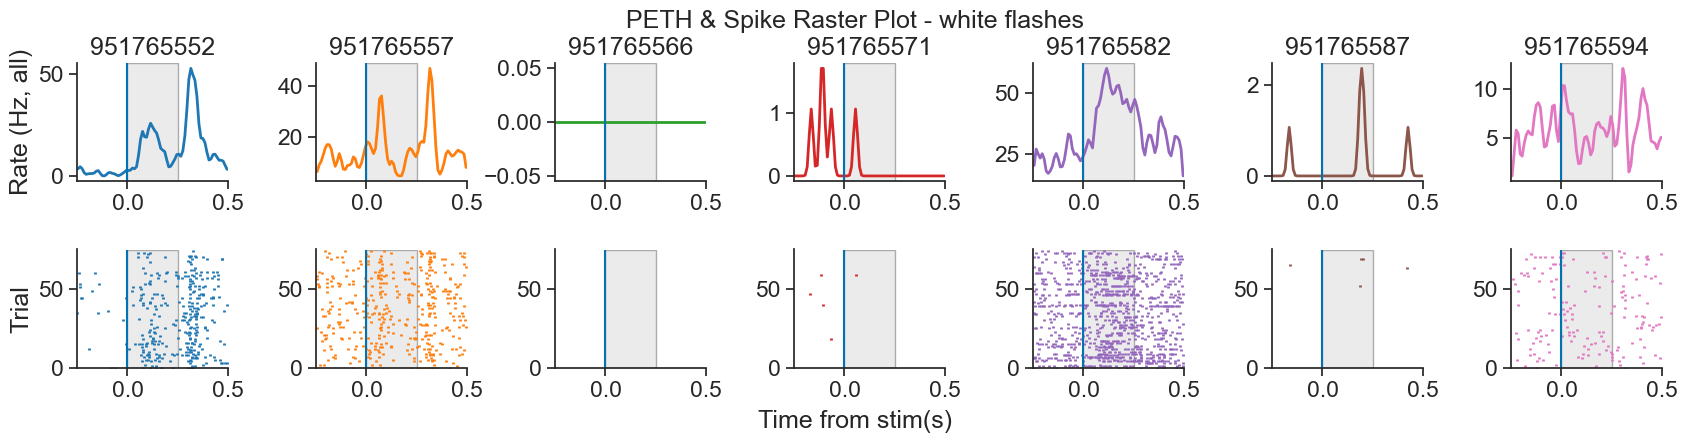

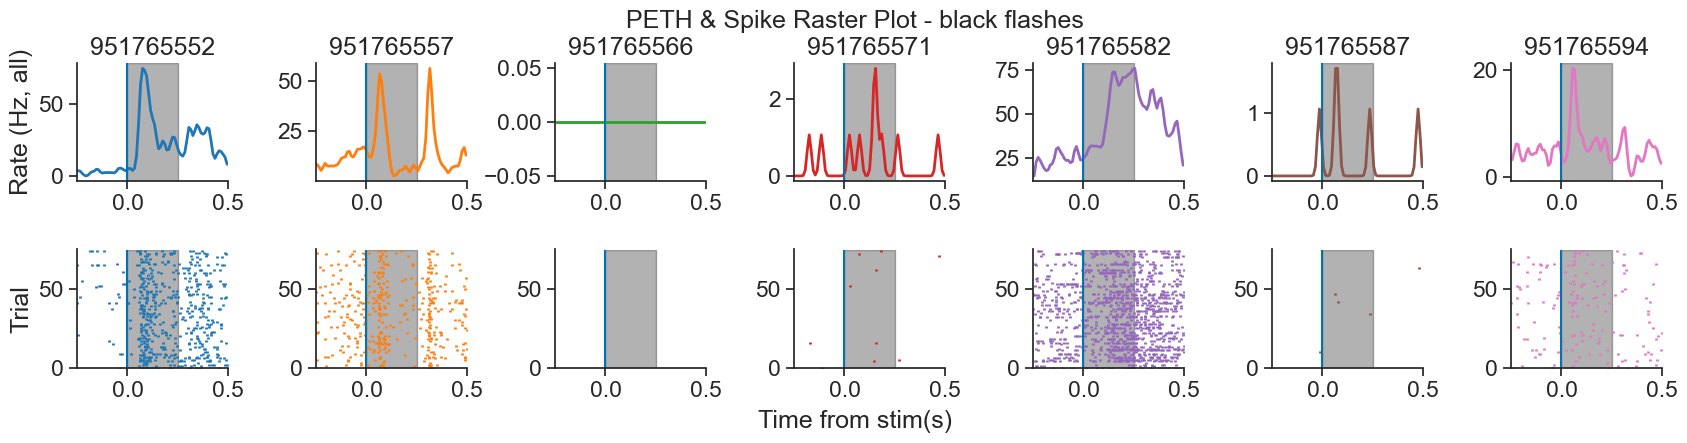

In [17]:
bin_sz = 0.005 # Bin size

plot_raster_peth(peri_white, units, "white", bin_sz)
plot_raster_peth(peri_black, units, "black", bin_sz)

951765552

:::{admonition} How to choose bin size?
:class: info
:class: dropdown

The bin size (```bin_sz```) refers to the size of the "binning" of the time series. A bin size of 0.005 means that one second will be split into 200 bins. Larger bins indicate lower temporal resolution, while smaller bins indicate higher temporal resolution. In this tutorial, we chose 0.005 as bin size , but it is worth noting that are different ways of calculating this value. How many bins you need depends on the temporal resolution of the process that you are modeling. This is a modelers choice, and there is no bin size fits all!
:::

:::{admonition} Why does the peth plot look so smooth?
:class: info
:class: dropdown

We use are using the [`smooth`](https://pynapple.org/generated/pynapple.Tsd.smooth.html#pynapple.Tsd.smooth) function from Pynapple to apply Gaussian smoothing to the perievent time series before plotting. This reduces trial-to-trial variability and emphasizes consistent temporal patterns in firing rate, making features like peaks or latency shifts easier to interpret—especially when spike trains are noisy or sparse.

In this tutorial, we use a Gaussian kernel with a standard deviation of 0.015 seconds.  
Given our bin size of `bin_sz = 0.005`, the sampling rate is: ```1 / bin_sz = 200 Hz```

This means we smooth over approximately 3 time bins.

For implementation details, refer to the [Pynapple documentation](https://pynapple.org/generated/pynapple.Tsd.smooth.html#pynapple.Tsd.smooth).

:::

In the plot above, we can see that some units (951765552, blue) are clearly more responsive than others (951765571, red - or even 951765566, green), which are apparently not modulated by the flashes. Thus, it would make sense to take a subset of the neurons, the most responsive ones, and model those.

We will now calculate responsiveness for each neuron as the normalized difference between average firing rate before and after stimulus presentation, and select the most responsive ones for further analyses.

In [18]:
def get_responsiveness(perievents, bin_sz):
    """Calculate responsiveness for each neuron. This is
    computer as:

    post_stim_av  : 
        Average firing rate during presentation (250ms) of stimulus across
        all instances of stimulus. 

    pre_stim_av :
        Average firing rate prior (250ms) to the presentation of stimulus
        accross all instances prior of stimulus. 

    responsiveness : 
        (post_stim_ave - pre_stim_av) / (post_stim_ave + pre_stim_av)

    Larger values indicate higher responsiveness to the stimuli.
        
    Parameters
    ----------
    perievents : TsGroup
        Contains perievent information of a subset of neurons
    bin_sz : float
        Bin size for calculating spike counts

    Returns
    ----------   
    resp_array : np.array
        Array of responsiveness information.
    resp_dict : dict
        Dictionary of responsiveness information. Indexed by each neuron's,
        contains responsiveness, pre_stim_av and post_stim_av information

    """
    resp_dict = {}
    resp_array = np.zeros(len(perievents.keys()), dtype=float)

    for index,unit in enumerate(perievents.keys()):
        # Count the number of timestamps in each bin_sz bin.
        peri_counts = perievents[unit].count(bin_sz)

        # Get the firing rate
        peri_rate = peri_counts/bin_sz

        # Compute average firing rate for each milisecond in the
        # the 250ms before stimulus presentation
        pre_stim = np.mean(peri_rate,1).restrict(nap.IntervalSet([-.25,0]))

        # Compute average firing rate for each milisecond in the
        # the 250ms after stimulus presentation
        post_stim = np.mean(peri_rate,1).restrict(nap.IntervalSet([0,.25]))

        pre_stim_av = np.mean(pre_stim)
        post_stim_av = np.mean(post_stim)
        responsiveness = (post_stim_av - pre_stim_av) / (post_stim_av + pre_stim_av)

        resp_dict[unit] = {
            "responsiveness": responsiveness,
            "pre_stim_av": pre_stim_av,
            "post_stim_av": post_stim_av,
        }
        resp_array[index] = responsiveness

    return resp_array, resp_dict

In [19]:
# Calculate responsiveness
responsiveness_white,_ = get_responsiveness(peri_white, bin_sz)
responsiveness_black,_ = get_responsiveness(peri_black, bin_sz)

# Add resposiveness as metadata for units
units.set_info(responsiveness_white=responsiveness_white)
units.set_info(responsiveness_black=responsiveness_black)

# See metadata
print(units)

Index      rate      quality    brain_area    responsiveness_white    responsiveness_black
---------  --------  ---------  ------------  ----------------------  ----------------------
951765440  9.97935   good       VISp          -0.14                   0.28
951765454  5.47349   good       VISp          -0.02                   0.02
951765460  4.44892   good       VISp          0.18                    0.0
951765467  9.98162   good       VISp          -0.17                   0.22
951765478  17.40465  good       VISp          0.2                     0.33
951765485  13.97731  good       VISp          0.15                    -0.39
951765508  2.13461   good       VISp          -0.46                   -0.23
...        ...       ...        ...           ...                     ...
951768894  9.16155   good       VISp          -0.09                   0.46
951768901  3.99186   good       VISp          -0.09                   -0.08
951768907  2.85765   good       VISp          0.49               

Now I can remove units without any firing throughout the whole stimulus presentation, with 0 responsiveness and also keep the top 30% most responsive units for ongoing analyses

In [20]:
# Nan values ocurr when there is division by zero aka firing rate before + firing rate after = 0 
units = units[~np.isnan(units["responsiveness_black"]) & ~np.isnan(units["responsiveness_white"])]

# Remove units with 0 responsiveness
units = units[(np.abs(units["responsiveness_black"])>0.01 ) & (np.abs(units["responsiveness_white"]) >0.01)]

# Get threshold for top 30% most resopnsive
thresh_black = np.percentile(units["responsiveness_black"], 70)
thresh_white = np.percentile(units["responsiveness_white"], 70)

# Only keep units that are within the 30% most responsive for either black or white
units = units[(units["responsiveness_black"] > thresh_black) | (units["responsiveness_white"] > thresh_white)]

print(units)

Index      rate      quality    brain_area    responsiveness_white    responsiveness_black
---------  --------  ---------  ------------  ----------------------  ----------------------
951765530  2.95127   good       VISp          0.69                    0.79
951765552  2.32971   good       VISp          0.75                    0.81
951765571  2.77426   good       VISp          -0.6                    0.5
951765582  14.77795  good       VISp          0.3                     0.36
951765587  2.62793   good       VISp          0.5                     0.5
951765647  9.12497   good       VISp          1.0                     0.07
951765666  9.72245   good       VISp          0.49                    0.44
...        ...       ...        ...           ...                     ...
951768830  10.90978  good       VISp          0.15                    0.47
951768881  2.06258   good       VISp          0.5                     0.27
951768888  2.90921   good       VISp          -0.2                   

### Revision of stimuli and spiking

Now that we have selected the units for our analyses, we can see how some of these neurons look in response to the stimuli in a PETH

In [21]:
def plot_peri_side_by_side(params,
                           bin_sz,
                           simulation = False,
                           smoothing = 0.015,
                           ):
    """ Top neurons should be range from 0 to last shape dim in case of simulation
    """
    peri_white, peri_black = params

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # 1 row, 2 columns

    # Plot White
    ax = axs[0]
    
    for unit in list(peri_white.keys()):
        if simulation and not hist: 
            peri_u = np.mean(peri_white,axis=1)[:,unit]
            ax.plot(peri_u, linewidth=1)
        else:
            peri_u = peri_white[unit]
            peri_u_count = peri_u.count(bin_sz)

            peri_u_coun_conv_mean = np.mean(peri_u_count, 1).smooth(std=smoothing)
            peri_u_rate_conv = peri_u_coun_conv_mean / bin_sz
            ax.plot(peri_u_rate_conv, linewidth=1)
    

    ax.set_xlim(-0.25, 0.50) # restrict
    ax.axvspan(0, 0.250, color="silver", alpha=0.3, ec="black")
    ax.axvline(0.0, color="black")
    ax.set_ylabel("Firing rate (Hz)")
    ax.set_title("Perievent white flashes")

    # Plot Black
    ax = axs[1]
    for unit in list(peri_black.keys()):
        if simulation: 
            peri_u = np.mean(peri_black,axis=1)[:,unit]
            ax.plot(peri_u, linewidth=1)
        else:
            peri_u = peri_black[unit]
            peri_u_count = peri_u.count(bin_sz)

            peri_u_coun_conv_mean = np.mean(peri_u_count, 1).smooth(std=smoothing)
            peri_u_rate_conv = peri_u_coun_conv_mean / bin_sz
            ax.plot(peri_u_rate_conv, linewidth=1)

    ax.set_xlim(-0.25, 0.50) # restrict
    ax.axvspan(0, 0.250, color="black", alpha=0.3, ec="black")
    ax.axvline(0.0, color="black")
    ax.set_title("Perievent black flashes")
    fig.text(0.5, -.01, 'Time from stim(s)', ha='center')

    plt.tight_layout()
    plt.show()


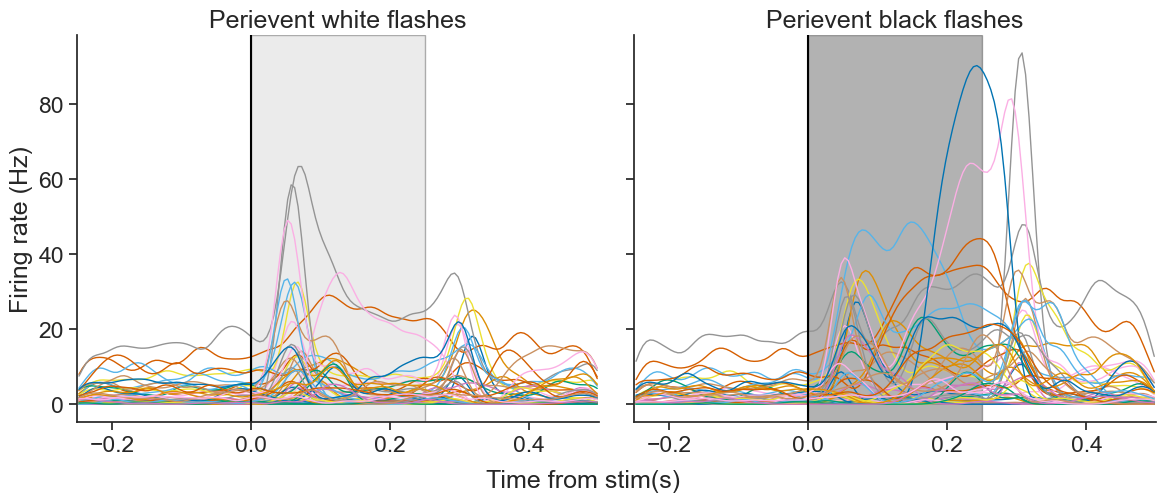

In [22]:
# Calculate perievent for white stimuli - subset of units
peri_white = nap.compute_perievent(timestamps = units,
                                        tref = flashes_white.starts,
                                        minmax = window_size
)

# Calculate perievent for black stimuli - subset of units
peri_black = nap.compute_perievent(timestamps = units,
                                        tref = flashes_black.starts,
                                        minmax = window_size
)

params_obs = [peri_white, 
              peri_black]

plot_peri_side_by_side(
    params_obs,
    bin_sz
)

or in a raster plot!

In [23]:
def raster_plot(units, n_neurons = len(units), n_flashes = 5, n_seconds = 13, offset = .5):
    n_neurons = len(units)
    n_flashes = 5
    n_seconds = 13
    offset = .5

    start = data["flashes_presentations"]["start"].min() - offset # Start a little bit earlier than the first flash presentation
    end = start + n_seconds

    # Restrict the neurons to the period of presentation of plotted stimuli
    units = units.restrict(nap.IntervalSet(start, end))

    # Change type to tsd to access spiking times. 
    # Change the metadata information so each different 
    # neuron is now tagged with an ID from 1 to 10
    # for ease of plot
    neurons_to_plot = units.to_tsd([i+1 for i in range(n_neurons)])

    fig, ax = plt.subplots(figsize = (17, 4))

    ax.plot(neurons_to_plot, "|", markersize=2, mew=2)

    # Different coloured flashes
    [ax.axvspan(
        s, 
        e, 
        color = "silver", 
        alpha=.4, 
        ec="black"
        ) for s, e in zip(
            flashes_white[:n_flashes].start, 
            flashes_white[:n_flashes].end
        )
    ]

    [ax.axvspan(
        s, 
        e, 
        color = "black", 
        alpha=.4, 
        ec="black"
        ) for s, e in zip(
            flashes_black[:n_flashes].start, 
            flashes_black[:n_flashes].end
        )
    ]

    plt.xlabel("Time (s)")
    plt.ylabel("Unit")
    ax.set_title("Primary Visual Cortex (VISp) units spikes and stimuli")
    plt.xlim(start,end) 
    
    plt.show()

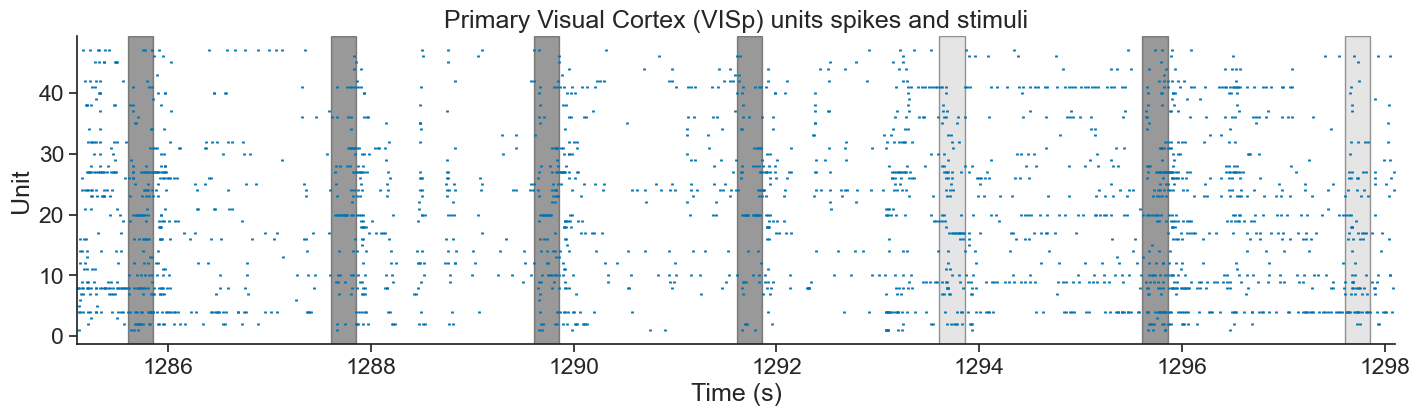

In [24]:
raster_plot(units)

Importantly, we are interested solely in the response of the unit around the stimuli. Let's restrict our time series around the stimuli presentation.

In [25]:
dt = .50
start = flashes.start - dt
end = flashes.end + dt

ep_flashes = nap.IntervalSet(start,end, metadata=flashes.metadata) 
ep_flashes_white = ep_flashes[ep_flashes["color"]=="1.0"]
ep_flashes_black = ep_flashes[ep_flashes["color"]=="-1.0"]

### Splitting the dataset in train and test
We could train the model with the whole dataset, but then we would not have a way to assess whether our model is capable of making accurate predictions or simply overfitting to our data. The simplest way around this is to have a reserved part of the data for testing. However, the precise details on how to do this splitting depends on the question, the data, and the researcher.

Here, we will split the data in two: 70% will be for training and 30% will be for testing. However, we can't simply grab the first 70% of the timeseries - what if we are biasing our sample and there are some neurons that respond only towards the end or the beginning of the experiment? For that, we will gather one every three flashes, and those will go to the testing set. The rest, will go to the training set.

In [26]:
# We take one every three flashes (33% of all flashes of test)
flashes_test_white = ep_flashes_white[::3]
flashes_test_black = ep_flashes_black[::3]

Pynapple has a nice function to get all the epochs: [```set_diff```](https://pynapple.org/generated/pynapple.IntervalSet.set_diff.html). With it, we can get all of the interval sets which are not in the interval set passed as argument.

In [27]:
# The remaining is separated for training
flashes_train_white = ep_flashes_white.set_diff(flashes_test_white)
flashes_train_black = ep_flashes_black.set_diff(flashes_test_black)

Consider black and white for test and train
using [```union```](https://pynapple.org/generated/pynapple.IntervalSet.union.html#pynapple.IntervalSet.union)

In [28]:
# Merge both stimuli types in a single interval set
flashes_test = flashes_test_white.union(flashes_test_black)
flashes_train = flashes_train_white.union(flashes_train_black)

Now that we have our intervals correctly, we can use [```restrict```](https://pynapple.org/generated/pynapple.TsGroup.restrict.html#pynapple.TsGroup.restrict) to get our test and train sets for units

In [29]:
# General spike counts
units_counts = units.count(bin_sz, ep = ep_flashes)

# Restrict counts to test and train
units_counts_test = units_counts.restrict(flashes_test)
units_counts_train = units_counts.restrict(flashes_train)

## Fitting a GLM

### Preparing the data for NeMos
Now that we have a good understanding of our data, and that we have splitted our dataset in the corresponding test and train subsets, we are almost ready to run our model. However, before we can construct it, we need to get our data in the right format.

When fitting a single neuron, NeMoS requires that the predictors and spike counts it operates on have the following properties:

- predictors and spike counts must have the same number of time points.
- predictors must be two-dimensional, with shape ```(n_time_bins, n_features)```. So far, we have two features in this tutorial: white and black flashes.
- spike counts must be one-dimensional, with shape ```(n_time_bins,)```. 
- predictors and spike counts must be jax.numpy arrays, numpy arrays or pynapple TsdFrame/Tsd.

When fitting multiple neurons, spike counts must be two-dimensional: ```(n_time_bins, n_neurons)```. Moreover, in that case, spike counts can be Pynapple TsGroup objects as well.

First, we require that our predictors and our spike counts have the same number of time bins.

In [30]:
# Create a ts frame filled by zeros, for the size of units_counts
predictors = nap.TsdFrame(t=units_counts.t, d=np.zeros((len(units_counts), 2)), columns = ['white', 'black'])

At the moment, the flashes are in a IntervalSet, we need to grab them and make them time series of stimuli, separated by black and white (because we are interested in how neurons' responses are modulated by each individual stimulus type separately).

In [31]:
# Check whether there is a flash within a given bin of spikes
# If there is not, put a nan in that index
idx_white = flashes_white.in_interval(units_counts)
idx_black = flashes_black.in_interval(units_counts)

# Replace everything that is not nan with 1 in the corresponding column
predictors.d[~np.isnan(idx_white), 0] = 1
predictors.d[~np.isnan(idx_black), 1] = 1

In [32]:
print(f"predictors shape: {predictors.shape}")
print(f"\ncount shape: {units_counts.shape}")

predictors shape: (37500, 2)

count shape: (37500, 47)


They match in the first dimension because they have the same number of timepoints! In the second dimension, predictors has 2 because there is two features (black and white). Meanwhile, in the second dimension, counts has 47 because the selected units for this tutorial sums to 47. 

Just to make sure that we got the right output, let's plot our new "predictors" time series as lines alongside our first plot

In [33]:
def stimuli_plot(predictors, n_flashes = 5, n_seconds = 13, offset = .5):
    n_flashes = 5
    n_seconds = 13
    offset = .5

    start = data["flashes_presentations"]["start"].min() - offset # Start a little bit earlier than the first flash presentation
    end = start + n_seconds


    fig, ax = plt.subplots(figsize = (17, 4))

    #ax.plot(neurons_to_plot, "|", markersize=2, mew=2)

    # Different coloured flashes
    [ax.axvspan(s, e, color = "silver", alpha=.4, ec="black") for s, e in zip(flashes_white[:n_flashes].start, flashes_white[:n_flashes].end)]
    [ax.axvspan(s, e, color = "black", alpha=.4, ec="black") for s, e in zip(flashes_black[:n_flashes].start, flashes_black[:n_flashes].end)]
    plt.plot(predictors["white"], "o-", color= "silver")
    plt.plot(predictors["black"], "o-", color= "black")


    plt.xlabel("Time (s)")
    plt.ylabel("Absent = 0, Present = 1")
    ax.set_title("Presented Stimuli")
    
    plt.xlim(start,end) # Note to Guillaume: cant remove xlim because if i do the plot looks weird at the beginning as if there was no spiking

    # Only use integer values for ticks
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.show()


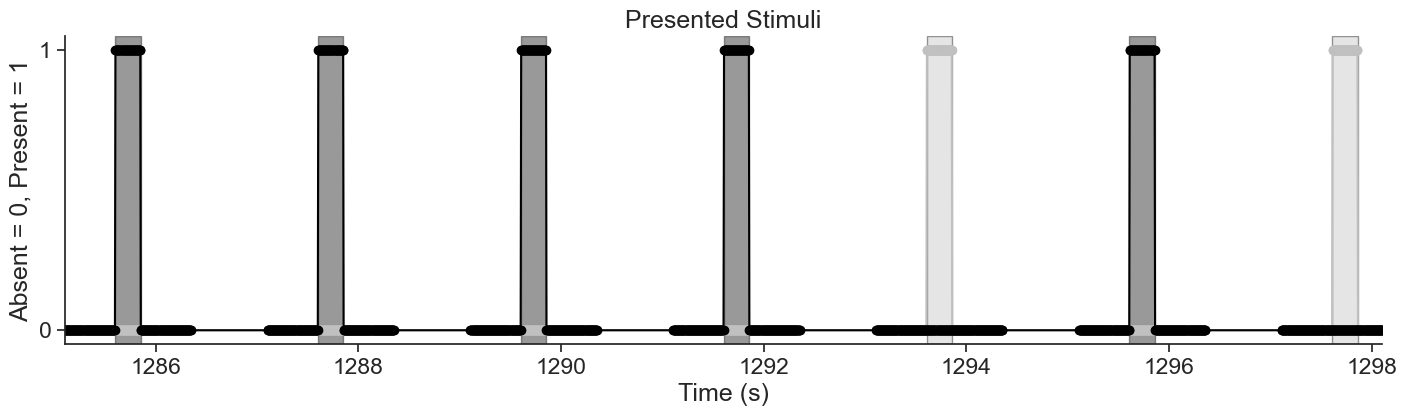

In [34]:
stimuli_plot(predictors)

They match perfectly! 

Secondly, we need to ensure our variables are the proper shape:

- ```predictors : (n_time_bins, n_features)```
- ```counts : (n_time_bins, n_neurons)```

When dealing with only one neuron, ```n_neurons = 1```. Right now, we do have the right shape so there is no more to do on this realm.

As a last preprocessing step, let's just split these predictors in train and test.

In [35]:
predictors_test = predictors.restrict(flashes_test)
predictors_train = predictors.restrict(flashes_train)

### Fitting the model

Now we are finally ready to fit our model!

First, we need to define our GLM model object. To initialize our model, we need to specify the ```solver_name```, the ```regularizer```, the ```regularizer_strength``` and the ```observation_model```. All of these are optional.

- ```solver_name```: this string specifies the solver algorithm. The default behavior depends on the regularizer, as each regularization scheme is only compatible with a subset of possible solvers.
- ```regularizer```: this string or object specifies the regularization scheme. Regularization modifies the objective function to reflect your prior beliefs about the parameters, such as sparsity. Regularization becomes more important as the number of input features, and thus model parameters, grows. NeMoS’s solvers can be found within the nemos.regularizer module. If you pass a string matching the name of one of our solvers, we initialize the solver with the default arguments. If you need more control, you will need to initialize and pass the object yourself.
- ```observation_model```: this object links the firing rate and the observed data (in this case spikes), describing the distribution of neural activity (and thus changing the log-likelihood). For spiking data, we use the Poisson observation model, but we discuss other options for continuous data in our documentation.

For this tutorial, we’ll use a LBFGS solver with Ridge regularization, and a regularization strength of 0.005.

:::{admonition} Why LBFGS?
:class: info
:class: dropdown

LBFGS is a quasi-Netwon method, that is, it uses the first derivative (the gradient) and approximates the second derivative (the Hessian) in order to solve the problem. This means that LBFGS tends to find a solution faster and is often less sensitive to step-size. Try other solvers to see how they behave!
:::

:::{admonition} What is regularization?
:class: info
:class: dropdown

When fitting models, it is generally recommended to use regularization, a technique that adds a constraint or penalty to the model’s cost function. Regularization works by discouraging the coefficients from reaching large values.

Penalizing large coefficients is beneficial because it helps prevent overfitting, a phenomenon in which the model fits the training data too closely, capturing noise instead of the underlying pattern. Large coefficients often indicate a model that is too complex or sensitive to small fluctuations in the data. By keeping coefficients smaller and more stable, regularization promotes simpler models that generalize better to unseen data, improving predictive performance and robustness.

In this tutorial, we will use Ridge regularization (or L2 regularization). In this type of regularization, the penalty term added to the loss function is:

$$
\text{Penalty} = \frac{\lambda}{2N} \sum_{j} \theta_j^2
$$

where $\lambda$ is the regularization strength, $N$ is the number of samples and $\theta_j$ are the model coefficients, stored in model.coef_

Please refer to [NeMos documentation](https://nemos.readthedocs.io/en/latest/generated/regularizer/nemos.regularizer.Ridge.html#nemos.regularizer.Ridge) for more details on how this was implemented.

:::

:::{admonition} Where did the regularization strength value come from?
:class: info
:class: dropdown

We conducted cross validation to obtain the regularization strength:

```
# Initialize model object
model_unit = nmo.glm.GLM(
    regularizer = "Ridge",
    regularizer_strength = 0.01,
    solver_name="LBFGS", 
    #solver_kwargs=dict(tol=10**-12)
)

# Create parameter grid
param_grid = {
    "regularizer_strength" : 
    np.geomspace(10**-9, 10, 10)
}

# Instantiate the grid search object
grid_search = GridSearchCV(
    model_unit,param_grid, 
    cv=2
    )

# Run grid search
grid_search.fit(X_train, u_counts_train)

# Print optimal parameter
print(grid_search.best_estimator_.regularizer_strength)
>>> 0.004641588833612782
```
::: 

In [36]:
# Initialize model object
model_unit = nmo.glm.GLM(
    regularizer = "Ridge",
    regularizer_strength = 0.005,
    solver_name="LBFGS", 
)

### Constructing the design matrix using basis functions

We aim to model each unit’s response to 250 ms full-field flashes by capturing how stimulus history over that duration influences spiking. We therefore define a 250 ms stimulus window, aligned with the flash onset, which spans the entire stimulus duration. This window enables the GLM to learn how the neuron's firing rate evolves throughout the flash, including both transient and sustained components of the response. Using a shorter window could omit delayed effects, while a longer window may incorporate unrelated post-stimulus activity.

To construct our stimulus history predictor, we could generate time-lagged copies of the stimulus input (in the form of a [Hankel Matrix](https://en.wikipedia.org/wiki/Hankel_matrix)). Specifically, the value of the first predictor at time $ t $ would correspond to the stimulus at time $ t $, while the second predictor would capture the stimulus at time $ t - 1 $ , and so on, up to a maximum lag corresponding to the length of the stimulus integration window (250 ms in our case).

:::{admonition} How do you build a Hankel matrix?
:class: info
:class: dropdown

Every row is a shifted copy of the row above!

![henkel_matrix](../../data/images/henkel_matrix.gif)

Construction of Hankel Matrix. Modified from <a href="https://pillowlab.princeton.edu/pubs/pillow_TutorialSlides_Cosyne2018.pdf">Pillow 2018 Cosyne tutorial </a>

:::


However, modeling each time lag with an independent parameter leads to a high-dimensional filter that is prone to overfitting! (Given that we are using a bin size of 0.002, we would end up with 125 lags = 125 parameters per flash color!) A better idea is to do some dimensionality reduction on these predictors, by parametrizing them using basis functions. These will allow us to capture interesting non-linear effects with a relatively low-dimensional parametrization that preserves convexity. NeMoS has a whole library of basis objects available at [```nmo.basis```](https://nemos.readthedocs.io/en/latest/background/basis/README.html#table-basis), and choosing which set of basis functions and their parameters, like choosing the duration of the flash history predictor, requires knowledge of your problem, but can later be examined using model comparison tools.

For history-type inputs like we’re discussing, the raised cosine log-stretched basis first described in [Pillow et al., 2005](https://www.jneurosci.org/content/25/47/11003) is a good fit. This basis set has the nice property that their precision drops linearly with distance from event, which is a makes sense for many history-related inputs in neuroscience: whether an input happened 1 or 5 ms ago matters a lot, whereas whether an input happened 51 or 55 ms ago is less important.

:::{admonition} More resources on basis functions
:class: info
:class: dropdown
- [Nemos fit head-direction population tutorial](https://nemos.readthedocs.io/en/latest/tutorials/plot_02_head_direction.html): For a step by step explanation of how to build the design matrix first as a result of convolving the features with the identity matrix, and then by using basis functions, alongside nice visualizations.
- [Bishop, 2009](https://www.microsoft.com/en-us/research/wp-content/uploads/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf): Section 3.1 for a formal description of what basis functions are and some examples of them.
:::

NeMoS includes Basis objects to handle the construction and use of these basis functions.

When we instantiate this object, the only arguments we need to specify is the number of functions we want, the mode of operation of the basis ("conv"), and the window size for the convolution. With more basis functions, we’ll be able to represent the effect of the corresponding input with the higher precision, at the cost of adding additional parameters.

basis addition

place cells tutorial for explanation of composition of bases


- basis functions to reduce the number of features (dimensionality reduction - noise vs. a coefficient for every timepoint)
- smoothing or other assumptions

how to define them depends on the type of input

In [37]:
# Create basis for training
window_length = int(0.25 / bin_sz)

bas = (nmo.basis.RaisedCosineLogConv(
        n_basis_funcs = 5, 
        window_size = window_length, 
        label = "white"
    )
    + nmo.basis.RaisedCosineLogConv(
        n_basis_funcs = 5, 
        window_size = window_length, 
        label = "black"
    )
)

X_train = bas.compute_features(
    predictors_train["white"], 
    predictors_train["black"]
)

X_test = bas.compute_features(
    predictors_test["white"], 
    predictors_test["black"]
)

### Fitting a GLM: single unit
Now we are ready to fit our model!

First, we need to define our GLM model object. 

NeMos has an object for fitting GLMs [```GLM```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.GLM.html#nemos.glm.GLM). First, we initiate the object with the regularizer, regularizer_strength, solver _name and solver_kwargs. In this tutorial, we will use Ridge regularization, and a regularization strength of 0.005.

We can also see how good the model is in predicting this neuron's spikes by comparing the prediction with the actual activity using a PETH. To obtain the predicted spikes per bin, we can use the NeMos function [```predict```](https://nemos.readthedocs.io/en/latest/generated/glm/nemos.glm.GLM.predict.html#nemos.glm.GLM.predict)

In [38]:
# Choose an example unit
unit_id = 951765530

# Get counts for train and test for said unit
u_counts_train = units_counts_train.loc[unit_id]
u_counts_test = units_counts_test.loc[unit_id]

model_unit.fit(X_train, u_counts_train)

pred_unit = model_unit.predict(X_test)

# convert units from spikes/bin to spikes/sec
pred_unit = pred_unit/ bin_sz

# Using that predicted rate, we can compute a perievent
window_size = (-.250,.500)
peri_white_pred_unit = nap.compute_perievent_continuous(timeseries = pred_unit, 
                                        tref = nap.Ts(flashes_test_white.start+.50), # +50 because we added +.50 at beginning and end of stimulus
                                        minmax=window_size
)  
peri_black_pred_unit = nap.compute_perievent_continuous(timeseries = pred_unit, 
                                        tref = nap.Ts(flashes_test_black.start+.50), # +50 because we added +.50 at beginning and end of stimulus
                                        minmax=window_size
)  
# And we can compare it to that neurons perievent,
# which we calculated at the beginning of the notebook

In [39]:
def plot_peri_predict():
    fig, ax = plt.subplots(1,2,figsize=(17, 4), sharey=True)
    color = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
    ### white
    # predicted
    ax[0].plot(np.mean(peri_white_pred_unit,axis=1), linewidth=2, color="red", label = "predicted")

    peri_u = peri_white[unit_id]
    peri_u_count = peri_u.count(bin_sz)

    peri_u_count_conv_mean = np.mean(peri_u_count, 1).smooth(std=0.015)
    peri_u_rate_conv = peri_u_count_conv_mean / bin_sz
    # observed
    ax[0].plot(peri_u_rate_conv, linewidth=2, color=color)
    ax[0].axvline(0.0)
    ax[0].axvspan(0, 0.250, color="silver", alpha=0.3, ec="black")
    ax[0].set_xlim(-.25, .5)

    ax[0].set_title("White flashes")

    #### black
    # predicted
    ax[1].plot(np.mean(peri_black_pred_unit,axis=1), linewidth=2, color="red")

    peri_u = peri_black[unit_id]
    peri_u_count = peri_u.count(bin_sz)

    peri_u_count_conv_mean = np.mean(peri_u_count, 1).smooth(std=0.015)
    peri_u_rate_conv = peri_u_count_conv_mean / bin_sz
    # observed
    ax[1].plot(peri_u_rate_conv, linewidth=2, color=color, label = "observed")
    ax[1].axvline(0.0)
    ax[1].axvspan(0, 0.250, color="black", alpha=0.3, ec="black")
    ax[1].set_xlim(-.25, .5)

    ax[1].set_title("Black flashes")
    ax[0].set_ylabel("Rate (Hz)")

    fig.text(0.5, -.05, 'Time from stim(s)', ha='center')
    fig.text(0.5, .95, f'PETH unit {unit_id}', ha='center')
    fig.legend()
    plt.show()


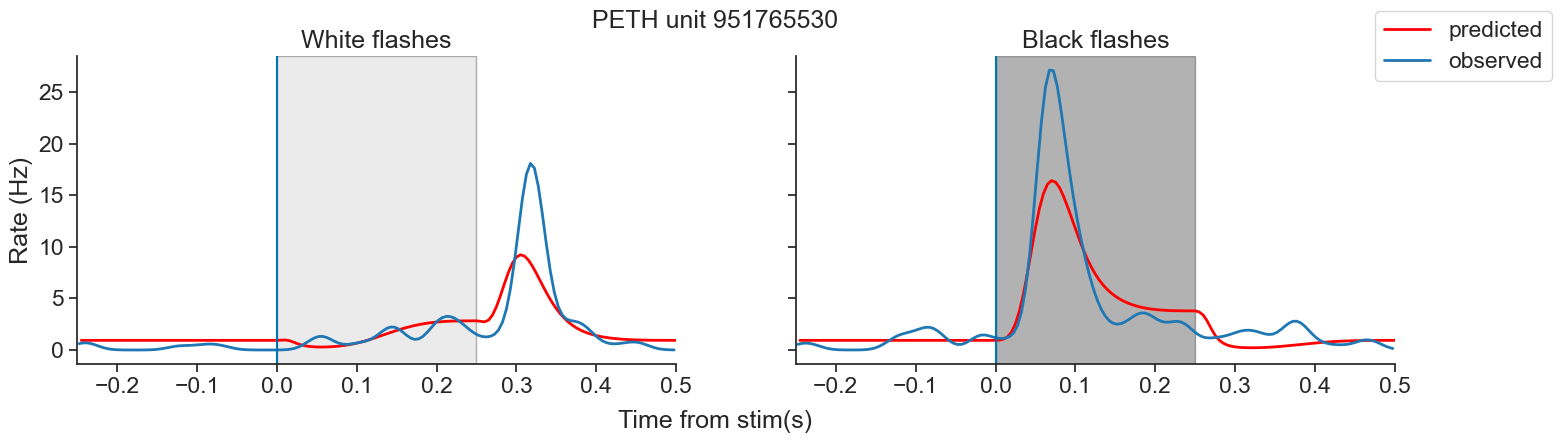

In [40]:
plot_peri_predict()

In this tutorial, for conciseness, we will use the regularizer strength obtained for this single neuron for the whole population. However, please note that when running your own analysis, it is necessary to find the optimal regularizer strength per neuron, as nothing guarantees that the optimal solution for this neuron will be the optimal solution for the next.

### Fit a PopulationGLM
Now we can move on to fit the population of units! NeMos has an object for fitting multiple units at once, [```PopulationGLM```](https://nemos.readthedocs.io/en/latest/how_to_guide/plot_03_population_glm.html). This is equivalent to fitting individually in a loop, but faster.


In [ ]:
model_base = nmo.glm.PopulationGLM(
    regularizer = "Ridge",
    regularizer_strength = 0.005,
    solver_name="LBFGS" 
)

model_base.fit(
    X_train,
    units_counts_train
)

PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=Ridge(),
    regularizer_strength=0.005,
    solver_name='LBFGS'
)

## Nemos: evaluating GLM
[Explanation]

### Perievent

In [42]:
predicted = model_base.predict(X_test)

# convert units from spikes/bin to spikes/sec
predicted = predicted/ bin_sz

In [43]:
# Calculate perievent for test set
peri_white_test = nap.compute_perievent_continuous(
    timeseries = units.restrict(flashes_test).count(bin_sz),
    tref = nap.Ts(flashes_test_white.start+.50),
    minmax = (window_size)
)

peri_black_test = nap.compute_perievent_continuous(
    timeseries =  units.restrict(flashes_test).count(bin_sz),
    tref = nap.Ts(flashes_test_black.start+.50),
    minmax = (window_size)
)

# Calculate perievent for predicted
peri_white_pred = nap.compute_perievent_continuous(
    timeseries = predicted, 
    tref = nap.Ts(flashes_test_white.start+.50),
    minmax=(window_size)
)  

peri_black_pred =  nap.compute_perievent_continuous(
    timeseries = predicted, 
    tref = nap.Ts(flashes_test_black.start+.50),
    minmax=(window_size)
)  

We have to do some preprocessing to plot

In [44]:
def create_zscore_dic(
        peri_white_test, 
        peri_black_test,
        peri_white_pred,
        peri_black_pred):
    
    restriction = [-.24, .25]  # 250ms before and after stimulus

    # Dictionary to store z-scores and orderings for test data
    dic_test = {
        "white": {"z": None, "order": None},
        "black": {"z": None, "order": None}
    }
    dic_pred = {
        "white": {"z": None},
        "black": {"z": None}
    }

    # Loop over test peri-event data
    for color, peri in zip(["white", "black"], [peri_white_test, peri_black_test]):
        # Restrict time window and average across trials
        mean_peri = np.mean(
            peri.restrict(nap.IntervalSet(restriction)), axis=1
        ).smooth(std=0.015)
        # Z-score across time bins for each neuron
        z_mean_peri = zscore(mean_peri, axis=0)
        # Sort neuron indices by peak time
        order = np.argsort(np.argmax(z_mean_peri, axis=0))
        # Sort neurons by time of peak response
        z_sorted = z_mean_peri[:, order]
        # Store in dictionary
        dic_test[color]["z"] = z_sorted
        dic_test[color]["order"] = order

    for color, peri in zip(
        ["white", "black"], 
        [peri_white_pred, peri_black_pred]):  
        # Restrict time window and average across trials
        mean_peri = np.mean(
            peri.restrict(nap.IntervalSet(restriction)), axis=1
        )
        # Z-score across time bins for each neuron
        z_mean_peri = zscore(mean_peri, axis=0)
        
        # Get test data order
        order = dic_test[color]["order"]

        # Get peak location (time bin) for each neuron
        #order = np.argmax(z_mean_peri, axis=0)

        # Sort according to test data
        z_sorted = z_mean_peri[:, order]
        # Store in dictionary
        dic_pred[color]["z"] = z_sorted

    return dic_test, dic_pred

In [45]:
dic_test, dic_pred = create_zscore_dic(
    peri_white_test, 
    peri_black_test,
    peri_white_pred,
    peri_black_pred)

In [46]:
def plot_zscores(dic_test, dic_pred):
##________WHITE
    fig, ax = plt.subplots(1,2)
    fig.tight_layout()

    fig.set_figheight(4)
    fig.set_figwidth(17)

    # Number of bins corresponds to the time axis
    # dic_test["white"]["z"] is shape times x units
    num_bins = dic_test["white"]["z"].shape[0] 

    # Create a time vector from -0.25 to 0.5 s with steps of bin_size
    time = np.arange(-0.24, 0.5, bin_sz)

    # Limits of image : x_min, x_max, y_min, y_max
    limits = [time[0], time[-1], 0, dic_test["white"]["z"].shape[1]]

    # .T because we want neurons on the y-axis and time on the x-axis
    # extent maps the x-axis (time) and y-axis (units index) correctly
    ######### Observed
    im = ax[0].imshow(
        dic_test["white"]["z"].T, 
        aspect="auto", 
        extent=limits
    )
    ax[0].set_title("Observed White")

    ######## Predicted
    im = ax[1].imshow(
        dic_pred["white"]["z"].T, 
        aspect="auto", 
        extent=limits
    )
    ax[1].set_title("Predicted White")
    # Stimulus
    ax[0].axvline(0.0)
    ax[1].axvline(0.0)
    ax[0].axvline(0.25)
    ax[1].axvline(0.25)

    fig.text(0.45, 0.00, 'Time from stim(s)', ha='center')  
    ax[0].set_ylabel("Unit")   
    ax[1].set_ylabel("Unit")             
    #plt.ylabel('Unit')                 
    #plt.title('Z-scored Predicted Firing Rates')  

    # Colorbar to indicate z-score values
    fig.colorbar(im,ax=ax, location = 'right', label='Z-score')      

    plt.show()

##________BLACK

    fig, ax = plt.subplots(1,2)
    fig.tight_layout()

    fig.set_figheight(4)
    fig.set_figwidth(17)

    # Number of bins corresponds to the time axis
    # dic_test["white"]["z"] is shape times x units
    num_bins = dic_test["white"]["z"].shape[0] 

    # Create a time vector from -0.25 to 0.5 s with steps of bin_size
    time = np.arange(-0.24, 0.5, bin_sz)

    # Limits of image : x_min, x_max, y_min, y_max
    limits = [time[0], time[-1], 0, dic_test["white"]["z"].shape[1]]
    # Observed black
    im = ax[0].imshow(
        dic_test["black"]["z"].T, 
        aspect="auto", 
        extent=limits
    )

    ax[0].set_title("Observed Black")

    # Predicted black
    im = ax[1].imshow(
        dic_pred["black"]["z"].T, 
        aspect="auto", 
        extent=limits
    )
    ax[1].set_title("Predicted Black")


    ax[0].axvline(0.0)
    ax[1].axvline(0.0)
    ax[0].axvline(0.25)
    ax[1].axvline(0.25)

    fig.text(0.45, 0.00, 'Time from stim(s)', ha='center')  
    ax[0].set_ylabel("Unit")   
    ax[1].set_ylabel("Unit")             
    #plt.ylabel('Unit')                 
    #plt.title('Z-scored Predicted Firing Rates')  

    # Colorbar to indicate z-score values
    fig.colorbar(im,ax=ax, location = 'right', label='Z-score')        
    plt.show()

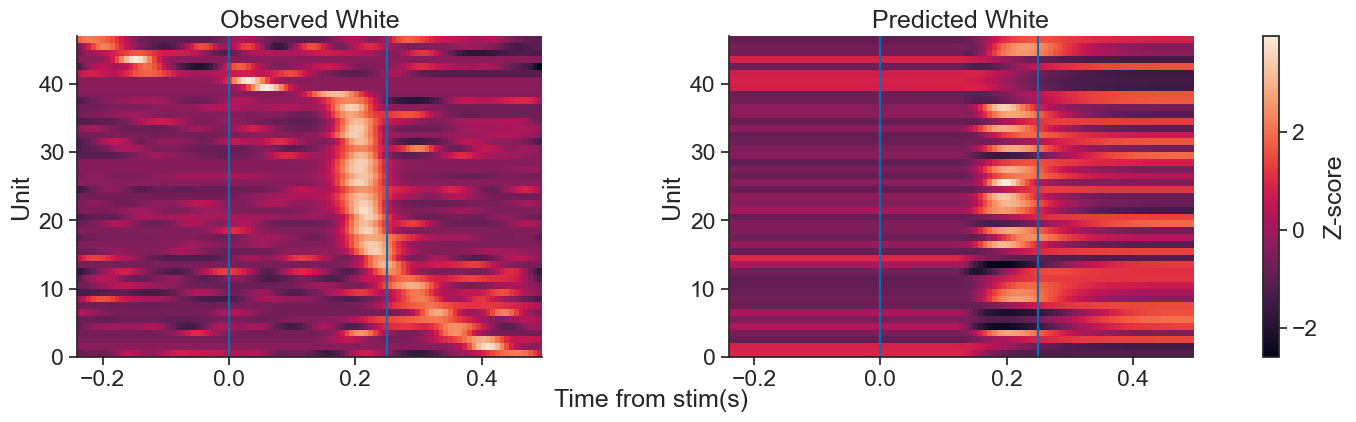

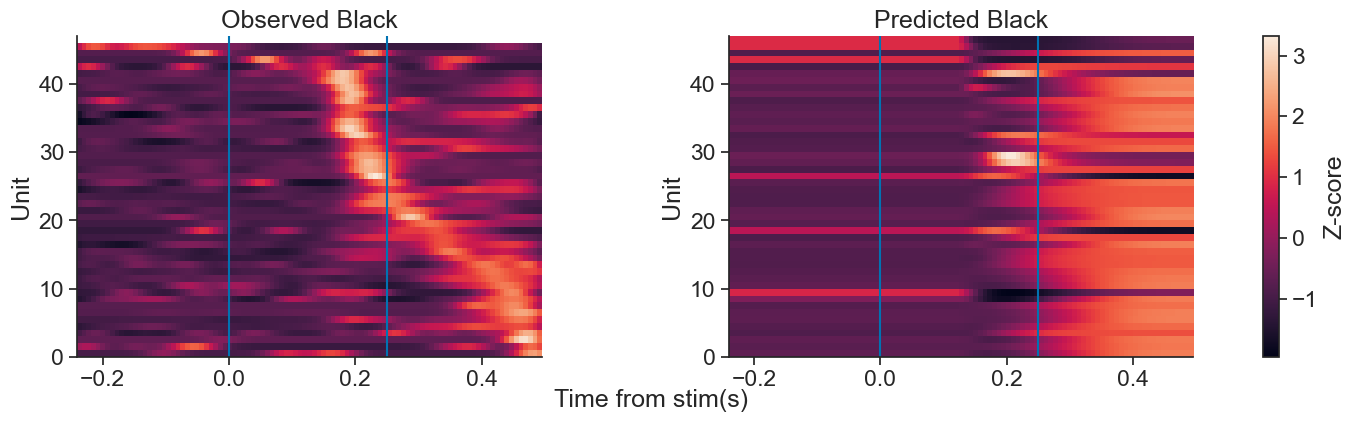

In [47]:
plot_zscores(dic_test, dic_pred)

explain smoothing 

add an admonition on why there is no prediction prior to the presentation of stimulus
admonition
taking an extra window because of the convolution thingy

## Adding history as a new predictor

So far, we have focused on the relatively simple LNP model of spike generation, which is a special case of a GLM. The LNP model has some known shortcomings. For instance, LNP ignores things like refactory periods and other history-dependent features of spiking in a neuron. Such spike history filters can be built into GLMs to give more accurate results. We will also show how, if you have recordings from a large population of neurons simultaneously, you can build connections between the neurons into the GLM in the form of coupling filters. This can help answer the degree to which activity is driven primarily by the input X, or by network influences in the population.

Now we would be interested in the question: can we use the spiking activity of other neurons to predict the spiking activity of a neuron? Would this work better at predicting activity than solely using stimuli (coloured flashes) as predictors?

We start by creating a new basis

In [48]:
# New basis
hist_bas = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs=8, window_size=window_length, label="spike_history"
)
stim_bas = bas

basis = stim_bas + hist_bas

X_hist_train = basis.compute_features(
    predictors_train["white"], 
    predictors_train["black"], 
    units_counts_train
)
X_hist_test = basis.compute_features(
    predictors_test["white"], 
    predictors_test["black"], 
    units_counts_test
)

In [ ]:
# Fit with new basis as predictor
# Fitting pop model
regularizer_strength = 0.01 #This should be checked with cross validation again, for this new model

model_hist = nmo.glm.PopulationGLM(
    regularizer = "Ridge",
    regularizer_strength = regularizer_strength,
    solver_name="LBFGS"
)

model_hist.fit(X_hist_train,units_counts_train)

PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=Ridge(),
    regularizer_strength=0.01,
    solver_name='LBFGS'
)

### Interpreting the coefficients?
The learned model coefficients are in a 2D array of shape ```(n_predictors, n_neurons)```. This array concatenates the coefficients representing pairwise couplings along the first dimension. Using the ```split_by_feature``` method of the basis object, the coefficients can be reshaped into a 3D array of shape ```(n_neurons, n_basis_funcs, n_neurons```, where the first dimension corresponds to sender neurons, the second dimension contains the basis function coefficients, and the third dimension corresponds to receiver neurons.

In [50]:
# get the dictionary (1 key per basis component, here there is single basis component)
weights_dict = basis.split_by_feature(model_hist.coef_, axis=0)

weights = weights_dict["spike_history"]

weights_sum = weights.sum(axis=1)

weights_sum.shape

(47, 47)

We can use this to ...?

### Assesment of model

In [51]:
predicted = model_hist.predict(X_hist_test)/ bin_sz

In [52]:
# Calculate perievent for predicted
peri_white_pred = nap.compute_perievent_continuous(
    timeseries = predicted, 
    tref = nap.Ts(flashes_test_white.start+.50),
    minmax=(window_size)
)  

peri_black_pred =  nap.compute_perievent_continuous(
    timeseries = predicted, 
    tref = nap.Ts(flashes_test_black.start+.50),
    minmax=(window_size)
)  

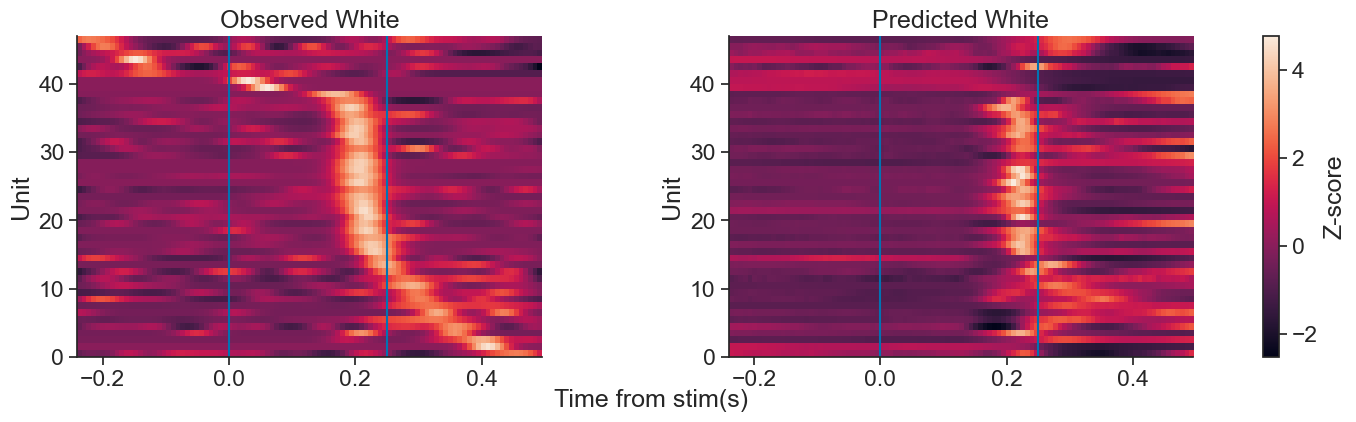

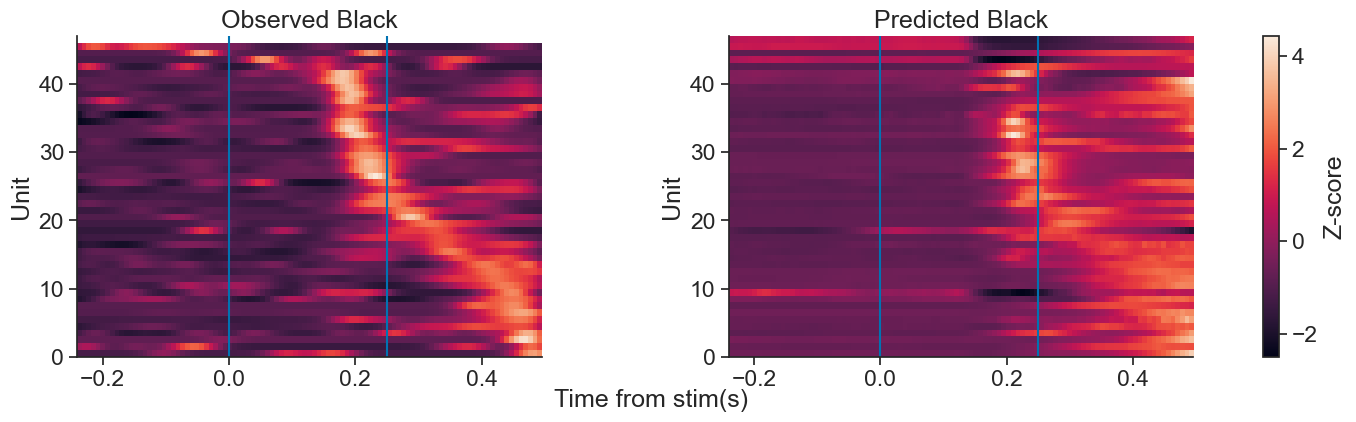

In [53]:
dic_test, dic_pred = create_zscore_dic(
    peri_white_test,
    peri_black_test,
    peri_white_pred,
    peri_black_pred
)

plot_zscores(dic_test, dic_pred)

Comment on plot

Responsiveness



## Evaluate performance
Sometimes one might want a value


We will use pseudo r squared, which is a normalized log likelihood base score between 0 and 1. It should not be interpreted as "variance explained", because this only works for linear models.

Admonition

Now we want to see which model has the best performance. When assesing this, it is important that we ask ourselves what is the most reasonable way to do it.

Usually, in linear regression, the $Rˆ2$ measure is used, which is interpreted as the proportion of explained variance by a given model:

$$
\begin{aligned}
R^2 = 1- \frac{\sum_i{(y_i - \hat{y})^2}}{\sum_i{(y_i - \mu)^2}}
\end{aligned}
$$

The numerator in this equation is the variance NOT explained by the model, while the denominator is the total variance of the model. For example, if a given model is perfect at predicting the mean but nothing else, then:

$$
\begin{aligned}
R^2 = 1- \frac{\sum_i{(y_i - \hat{y})^2}}{\sum_i{(y_i - \mu)^2}} = 1 - \frac{\sum_i{(y_i - \mu)^2}}{\sum_i{(y_i - \mu)^2}} = 1 - 1 = 0
\end{aligned}
$$

and the model explains very little of the variance.

Crucially, however, in GLMs, the variance has some characteristics that are incompatible with regular linear regression. In particular:
1. GLMs do not meet the homoscedasticity assumption necessary for linear regression (and $Rˆ2$ interpretation) to make sense. This assumption describes a situation in which the error term is the same across all samples; i.e. constant variance. In GLMs, the variance is not constant! In particular with LNP models, the variance is actually the same as the mean!
2. The $R^2$ captures the variance explained when there is a linear relationship between the observations and the predictor. However, in GLMs, the non-linearity sets a non-linear mapping between the predictors and the mean of the observations. Because of that, the variance explained interpretation does not hold either.




In [54]:
def evaluate_model(model, X, y):
    score_pop = model.score(
        X, 
        y, 
        score_type='pseudo-r2-McFadden',
    )
    score_unit = model.score(
        X, 
        y, 
        aggregate_sample_scores=lambda x:np.mean(x,axis=0), 
        score_type='pseudo-r2-McFadden',
    )
    return score_pop, score_unit 

def evaluate_models_by_color(models, X_sets, y_sets, flashes_color):
    '''
    Returns
    model base pop, model base unit, model hist pop, model hist unit
    '''
    models_list = []
    for model_name, model in models.items():
        X = X_sets[model_name].restrict(flashes_color)
        y = y_sets.restrict(flashes_color)
        models_list.append(evaluate_model(model, X, y))
    return models_list[0][0], models_list[0][1], models_list[1][0],models_list[1][1]

In [55]:
# Define model dictionary
models = {
    "base": model_base,
    "hist": model_hist
}


score_base_pop, score_base_unit = evaluate_model(
    models["base"],
    X_test,
    units_counts_test,
)

score_hist_pop, score_hist_unit = evaluate_model(
    models["hist"],
    X_hist_test,
    units_counts_test,
)

(score_white_base_pop, 
 score_white_base_unit, 
 score_white_hist_pop,
 score_white_hist_unit) = evaluate_models_by_color(
    models,
    {"base": X_test, 
    "hist": X_hist_test},
    units_counts_test,
    flashes_test_white
)

(score_black_base_pop, 
 score_black_base_unit, 
 score_black_hist_pop,
 score_black_hist_unit) = evaluate_models_by_color(
    models,
    {"base": X_test, 
    "hist": X_hist_test},
    units_counts_test,
    flashes_test_black
)

In [56]:
#print of scores

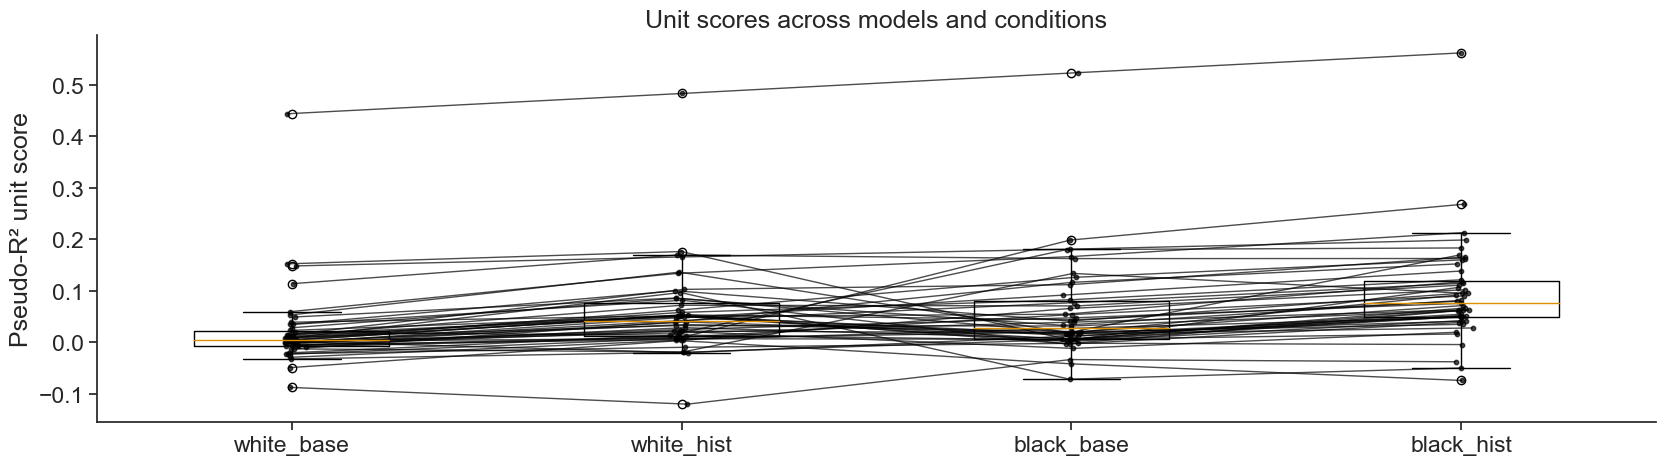

In [57]:
# Combine all arrays into a list
score_arrays = [
    score_white_base_unit,
    score_white_hist_unit,
    score_black_base_unit,
    score_black_hist_unit
]

labels = ["white_base", "white_hist", "black_base", "black_hist"]
num_conditions = len(score_arrays)
num_units = len(score_white_base_unit)

# X positions for boxplots (centered)
x_positions = np.arange(num_conditions)

plt.figure(figsize=(17, 5))

# Plot boxplots
plt.boxplot(score_arrays, positions=x_positions, widths=0.5)

# Scatter individual dots (jittered) and connect lines
for unit_idx in range(num_units):
    unit_scores = [arr[unit_idx] for arr in score_arrays]
    x_jittered = x_positions + np.random.normal(scale=0.01, size=num_conditions)
    
    # Scatter dots
    plt.scatter(x_jittered, unit_scores, color="black", s=10, alpha=0.7)

    # Connect dots for this unit
    plt.plot(x_jittered, unit_scores, color="black", alpha=0.7, linewidth=1)

# X-axis labels
plt.xticks(x_positions, labels)
plt.ylabel("Pseudo-R² unit score")
plt.title("Unit scores across models and conditions")
plt.tight_layout()
plt.show()


Let's select the neurons for which the history filter was actually better!

In [58]:
# get the dictionary (1 key per basis component, here there is single basis component)
weights_dict = basis.split_by_feature(model_hist.coef_, axis=0)

weights = weights_dict["spike_history"]

weights_sum = weights.sum(axis=1)

weights_sum.shape

(47, 47)

In [59]:
diff_white = score_white_hist_unit - score_white_base_unit
diff_black = score_black_hist_unit -  score_black_base_unit

mask_white = (diff_white > 0.05).astype(int)
mask_black = (diff_black > 0.05).astype(int)

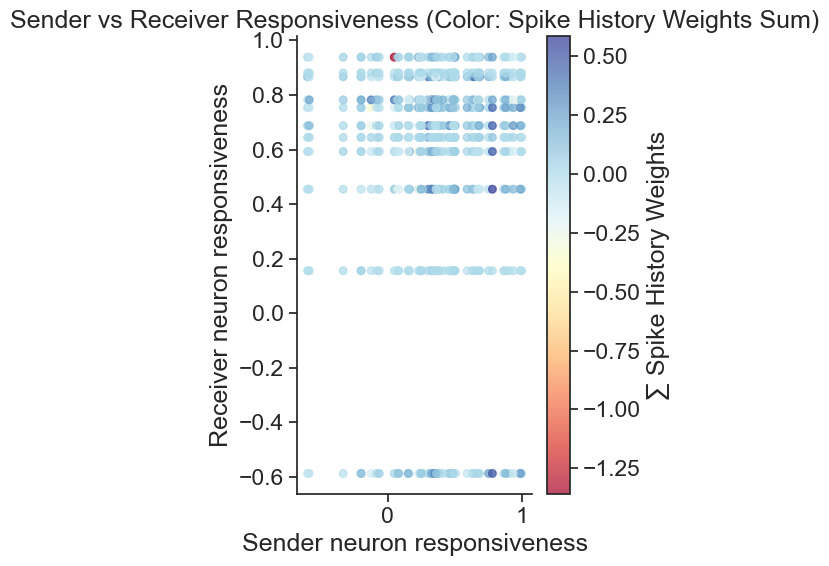

In [60]:
mask_bool = mask_white.astype(bool)  # ensure it's boolean

# Select only columns (i.e., select target neurons)
weights_selected = weights_sum[:, mask_bool]
weights_selected.shape


# Selected pairs
neuron_ids = list(units.index)  

mask_bool = mask_white.astype(bool)

# Apply mask to neuron_ids
masked_neuron_ids = [nid for nid, keep in zip(neuron_ids, mask_bool) if keep]

# Generate all pairs from masked neurons
pairs = [(s, r) for s, r in itertools.product(neuron_ids, masked_neuron_ids)]

pairs_ = [(s, r) for s, r in itertools.product(list(range(weights_selected.shape[0])),list(range(weights_selected.shape[1])))]

# Get responsiveness values
stimulus = "responsiveness_white"
x = [units[[s]][stimulus].values[0] for s, r in pairs]
y = [units[[r]][stimulus].values[0] for s, r in pairs]

idx_to_unit = list(units.index)
unit_to_idx = {unit: i for i, unit in enumerate(idx_to_unit)}

# Color: summed weights from spike history
colors = [weights_sum[s, r] for s, r in pairs_]

# Plot
plt.figure(figsize=(5, 6))
sc = plt.scatter(x, y, c=colors, cmap="RdYlBu", alpha=0.7, s=30)
plt.xlabel("Sender neuron responsiveness")
plt.ylabel("Receiver neuron responsiveness")
plt.title("Sender vs Receiver Responsiveness (Color: Spike History Weights Sum)")

# Colorbar
cbar = plt.colorbar(sc)
cbar.set_label("∑ Spike History Weights")

plt.tight_layout()
plt.show()

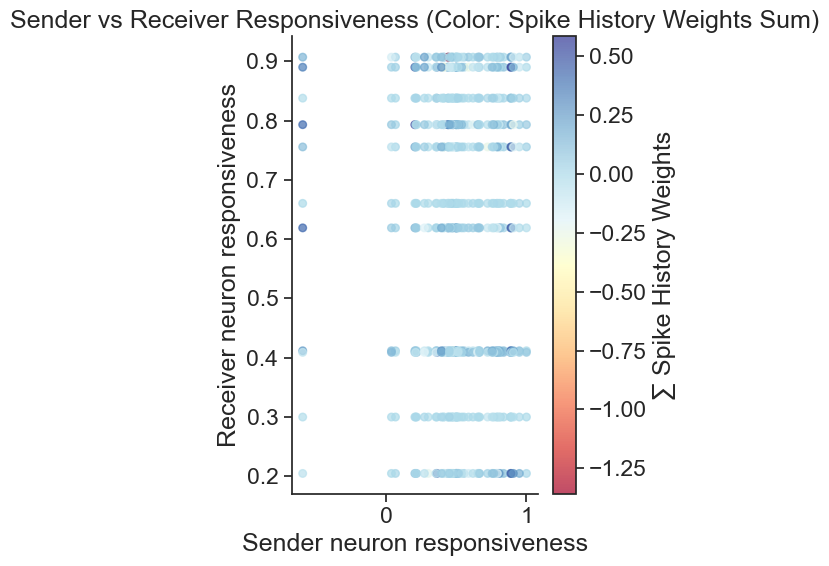

In [61]:
mask_bool = mask_black.astype(bool)  # ensure it's boolean

# Select only columns (i.e., select target neurons)
weights_selected = weights_sum[:, mask_bool]
weights_selected.shape


# Selected pairs
neuron_ids = list(units.index)  

mask_bool = mask_black.astype(bool)

# Apply mask to neuron_ids
masked_neuron_ids = [nid for nid, keep in zip(neuron_ids, mask_bool) if keep]

# Generate all pairs from masked neurons
pairs = [(s, r) for s, r in itertools.product(neuron_ids, masked_neuron_ids)]


pairs_ = [(s, r) for s, r in itertools.product(list(range(weights_selected.shape[0])),list(range(weights_selected.shape[1])))]

# Get responsiveness values
stimulus = "responsiveness_black"
x = [units[[s]][stimulus].values[0] for s, r in pairs]
y = [units[[r]][stimulus].values[0] for s, r in pairs]

idx_to_unit = list(units.index)
unit_to_idx = {unit: i for i, unit in enumerate(idx_to_unit)}

# Color: summed weights from spike history
colors = [weights_sum[s, r] for s, r in pairs_]

# Plot
plt.figure(figsize=(5, 6))
sc = plt.scatter(x, y, c=colors, cmap="RdYlBu", alpha=0.7, s=30)
plt.xlabel("Sender neuron responsiveness")
plt.ylabel("Receiver neuron responsiveness")
plt.title("Sender vs Receiver Responsiveness (Color: Spike History Weights Sum)")

# Colorbar
cbar = plt.colorbar(sc)
cbar.set_label("∑ Spike History Weights")

plt.tight_layout()
plt.show()

### References


##### ----
Formally, a GLM is a model for which $y$ is a non-linear function of a linear combination of the input variables so that

$y = f(wx+w_0)$,

where $f(.)$ is known as the activation function in machine learning literature and $f^{-1}(.)$ is known as the link function in statistics [(Bishop, 2009)](https://www.microsoft.com/en-us/research/wp-content/uploads/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf).


Comments on corrections
- increase threshold for selecting neurons (top 20%?) -- i dont think it looks a lot better so keeping 30%
- change everywhere text so its clear that 20% threshold

COMPLETED corrections:
- GLM admonition not being linear regression
- Links to pynapple objects
- plot basic stimulus
- short explanation of task and flashes
- for the sanity check plot, use coloured lines and same number of intervals
- Revise explanation of responsiveness markdown
- pull up explanation on perievent and make it larger
- Explain negative values in perievent
- Pull up red plot of perievent
- Explain lots of the neurons not responding, take subset
- fix explanation for splitting
- Fix bin size explanation
- do fitting with one neuron with and without regularization
- decide wether to use regul
- Admonition on regularization for history predictor if it wasnt there before
- clean responsiveness function
- remove unit admonition
- explanation of responsive units - chhange ids
- see to make bin size smaller (at end if necessary) -> 0.002
- implement regularization coefficient & make admonition of calculation of cross validation
- torial (in mice) remove parenthesis in mice
- add explanation on basis functions
- grid search in code block admonition - 0.005 as reg strength, which came to me in a dream
- Add single cell prediction pe
- "so we need to do some prep to extract from the nwb object. luckily, pynapple stores this for you"
- Extract flashes as an IntervalSet object
flashes = data["flashes_presentations"]
- xlim .5 end in pop and single
- for single, each column a different color
- -.5, .5 as flashes window but keep xlim on plots this is probably going to affect responsiveness computation so check that
- peri_white_test = nap.compute_perievent(timestamps = units_test,
                                        tref = nap.Ts(flashes_test_white.start+.25),
                                        minmax = (min_peri, max_peri)
) to +50
- zscore first, over time, each neuron independently
- plt.imshow(peri_white_pred.mean(1)[:, sort_idx].values.T) [four b w pred obs ]
- all axis must be commented
- ep_flashes (change name from dt)
- Just a one more preprocessing steps (remove the s) left to go!
- clean rasterplot code
- plot black peth as well
- plot for responsiveness ![IMG_9715.jpeg](attachment:IMG_9715.jpeg)
- increase to .50 zscore plot
- remove peth of subset of subset
- same reg strength for all, stop declaring!!!!
- Change image source to actual image source
- mention that i am smoothing the plot 
- center image
- perievents group should go up as well
- think of a better name for dt_flashes
- explain set diff
- smooth red plot
- improve explanation on design matrix
- improve explanation on basis
- get performance evaluation per single cel: pass a function to agreggate sample score - do mean over everything that isnt neuron mean(x,axis=1) mean over columns one score per neuron
- fix axes naming perievent plot red
- plot peth actual predicted with without regul 
- change window of perievent so it includes value 0
- improve phrasing for union flashes test and train

Currently working on:


Pending:
- Explain tolerance
- Fix scores plots
- ask wolf is explanation of smoothing is okat
- Should I remove neurons with 0 responsiveness?
- plot red peth for subset of neurons in hist
- explanation for fiting a glm
- explanation for fiting a pop glm
- explain objects for population glm
- explanation for adding history predictor
- finish explanation of performance evaluation
- explanation for performance evaluation
- basis function plot
- plot basis dot coefficient for that neuron
- improve resources about basis functions
- Present functions in a way that makes logical sense with the rest of the code
- Comment all functions
- Write explanations in markdown for all steps
- Find citations
- Update requirements
- Make id's consistent between units
- For perievents: maybe split neurons by firing rate? that would allow for the smaller firing rate ones not to be lost when compared to the large firing rate ones
- Add learning objectives
- Add estimated time of completion
- Add self-reflection questions (ideas - limitations for this model?)
- Fix admonitions
- Add more resources
- check all titles are uniform in terms of caps
- improve responsiveness explanation/notation
- Should I z-score firing rates so its easier to compare? in single unit raster
- Add smoothing to plotting added to hist!!!
- Read all of the texts
- change unit ids so they re always consistent
- references
- add single neuron plot for perievent predicted no smoothing
- revise order of background text
- Do responsiveness boxplot with information coefficient dot basis for each neuron

extra
- extend filter duration?

Other notes:
- In the selected neurons, some seem to not be very responsive at all?



optional
- color map by peak in responsiveness
- filter to 2hz during presentation of stimuli